In [1]:
 
import numpy as np
import matplotlib
from neo.io import AxonIO
#import seaborn as sns
import matplotlib.pyplot as plt
# import the data
#flydir = '/Volumes/hm_data/MN optogenetic activation/b1/1218 fly 3/'

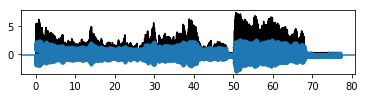

In [64]:
flydir = '/home/alysha/media/imager/FlyDataD/lysh_ephy_data_07_03/'
#lysh_ephy_data_07_03/'
#lysh_ephys_ata_old/


flydir = '/home/alysha/media/imager/FlyDataD/lysh_ephy_data_07_03/'


#localfile = flydir + '2018_03_05_0024.abf'
localfile = flydir + '2018_03_05_0020.abf'
 
r =AxonIO(localfile)
 
bl = r.read_block(lazy=False, cascade=True)
 
hutch = np.asarray(bl.segments[0].analogsignals[5])
 
fs_axon = 1.0/20000.0
 
times=np.linspace(0,len(hutch)/(1/fs_axon),len(hutch))
 
# detrend hütchens signal
hutch_det = hutch - np.mean(hutch)
 
ax1 = plt.subplot(311)
 
ax1.plot(times,hutch_det,'k')
 
#identify all relative minima
from scipy.signal import argrelmin
inds = argrelmin(hutch_det, order = 5)
ax1.plot(times[inds], hutch_det[inds], '.')
ax1.axhline(-0.08)
inds = np.array(inds)
inds = np.transpose(inds)
 

In [65]:
 
## identify the ventral flip of each wingbeat by applying a threshold
thresh = -.01 #adjust as needed
flipInds = []
flipInds = np.argwhere(hutch_det[inds]>thresh)
flipInds = inds[flipInds]
flipInds = flipInds[:,0]
 
#% now find the phase of the ventral flip 
 
#filter hütchen signal to make it more sinusoidal
 
from scipy import signal
from scipy.signal import butter, lfilter, freqz
 
def butter_lowpass(highcut, fs, order=4):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='low', analog=False)
    return b, a
 

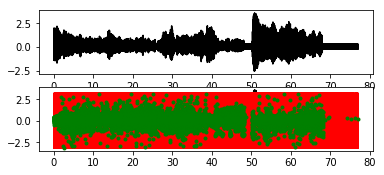

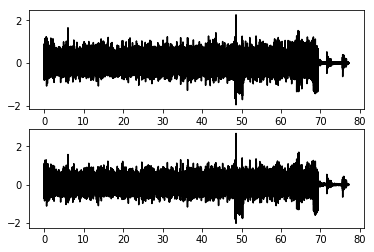

In [66]:
 
# Filter requirements.
order = 4
fs = 20000.0       # sample rate, Hz
lowcut = 100
highcut = 300.0  # desired cutoff frequency of the filter, Hz
 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(highcut, fs, order)
 
 
hutch_filt = signal.filtfilt(b, a, hutch_det)
 
ax2 = plt.subplot(312, sharex=ax1)
 
ax2.plot(times,hutch_filt,'k')
 
# perform a Hilbert transformation on the filtered signal to calculate instantaneous phase, amplitude, etc.
from scipy.signal import hilbert
 
hutch_analytic = hilbert(hutch_filt)
inst_phase = np.angle(hutch_analytic)
 
 
ax3 = plt.subplot(313, sharex=ax1)
 
# plot the identified ventral flip on the phase data
ax3.plot(times,hutch_analytic,'k')
ax3.plot(times,inst_phase,'r')
ax3.plot(times[flipInds],inst_phase[flipInds],'g.')


#%% detect muscle spikes and sort them
 
musc = np.asarray(bl.segments[0].analogsignals[0])
 
plt.figure(2)
ax1 = plt.subplot(211)
ax1.plot(times,musc,'k')
 
#apply median filter and detrend muscle signal
 
musc_det = musc-signal.medfilt(musc,35)
 
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times,musc_det,'k')
 
# threshold the detrended signal (convert the spikes into binary)
# calculate the change in, identify the spike starts/stops 
#thresh = 4
thresh =  0.6 #1.1
deltas = np.diff(np.array(-1*musc_det>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]

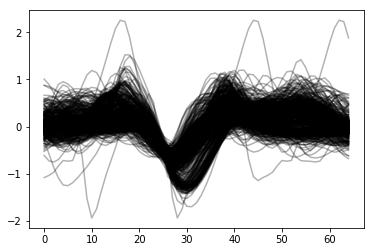

In [67]:
  
#find the peak changes in the thresholded signal, and find the associated waveform   
intervals = np.hstack((starts,stops))
spiketimes = [np.argmax(musc[sta:stp])+sta for sta,stp in intervals][2:-2]
waveforms = [musc[pk-25:pk+40] for pk in spiketimes]
 
#plot the collected waveforms
plt.figure(3)
for i in range(len(waveforms)):
    plt.plot(waveforms[i], 'k', alpha = 0.3)
 
wv_mtrx = np.vstack([np.array(wv) for wv in waveforms])

 
#%% extract the features of the waveforms to cluster the data
 
cov_wav = np.cov(wv_mtrx.T)
eig_vals, eig_vecs = np.linalg.eig(cov_wav)
#for ev in eig_vecs:
    #np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

[[-0.4844126  -0.2618804 ]
 [-3.15941926  0.46461751]]


' \ntest3 = np.argwhere(labels=0)\n\nfor i in range(len(test3)):\n   plt.plot(wv_mtrx[test3[i]])\n'

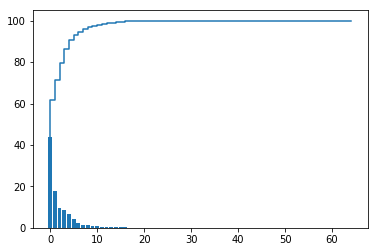

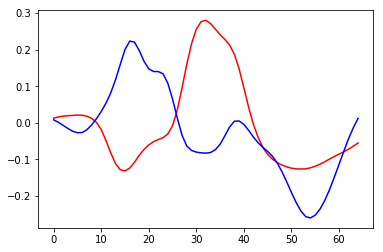

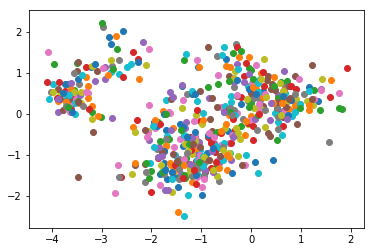

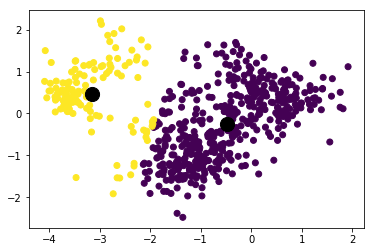

In [68]:
 
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
 
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)
 
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
 
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
 
plt.figure(4)
plt.bar(range(65), var_exp)
plt.step(range(65), cum_var_exp)
 
#contruct the projection matrix
matrix_w = np.hstack((eig_pairs[0][1].reshape(65,1),
                      eig_pairs[1][1].reshape(65,1)))
 
plt.figure(5)
plt.plot(matrix_w[:,0],'r')
plt.plot(matrix_w[:,1],'b')
 
plt.figure(6)
proj = []
proj1 = []
proj2 =[]
for i in range(len(wv_mtrx)):
    musc_proj = np.dot(wv_mtrx[i], matrix_w)
    proj.append(musc_proj[0])
    proj1.append(musc_proj[1])
    proj2.append(musc_proj)
    plt.scatter(musc_proj[0], musc_proj[1])
 
     
X = np.array(list(zip(proj, proj1)))
 
#%%
from sklearn.cluster import KMeans
 
# Number of clusters
#kmeans = KMeans(n_clusters=2)
#n_clusters=1
n_clusters=2
kmeans = KMeans(n_clusters=2)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
 
#print(C) 
print(centroids)
 
plt.figure(7)
plt.scatter(X[:, 0], X[:, 1], c=labels)
 
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200);
 
""" 
test3 = np.argwhere(labels=0)
 
for i in range(len(test3)):
    plt.plot(wv_mtrx[test3[i]])
"""

In [69]:
    
#%%


###### categorize and plot the labels 

labeled_spikes= zip(spiketimes,labels)

In [70]:
def cutoff(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Type_a_spikes = cutoff(0.5, labeled_spikes)

In [71]:
def cutoff_2(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Type_b_spikes = cutoff_2(0.5, labeled_spikes)

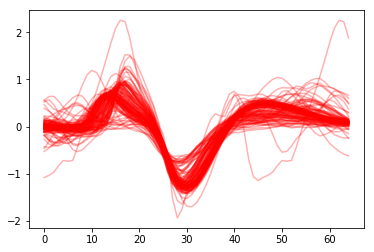

In [72]:
#print(zip_hutch)
#
#x_val = [x[0] for x in Type_a_spikes]
#y_val = [x[1] for x in Type_a_spikes]

Type_b_spikes = Type_a_spikes

x_val_b = [x[0] for x in Type_b_spikes]
y_val_b = [x[1] for x in Type_b_spikes]



#labeled_waveforms_type_a = [musc[pk-25:pk+40] for pk in x_val]

labeled_waveforms_type_b = [musc[pk-25:pk+40] for pk in x_val_b]
 
#plot the collected waveforms
#plt.figure(3)
#for i in range(len(labeled_waveforms_type_a)):
#    plt.plot(labeled_waveforms_type_a[i], 'b', alpha = 0.3)

plt.figure(3)
for i in range(len(labeled_waveforms_type_b)):
    plt.plot(labeled_waveforms_type_b[i], 'r', alpha = 0.3)

#%%
### delete this freq shit
###Use Hilbert function againt o calculate the instantaneous freq. of B2

plt.figure(12)

# Filter requirements.
order = 10  #4
fs = 20000.0       # sample rate, Hz
lowcut = 100
highcut = 200.0  # desired cutoff frequency of the filter, Hz

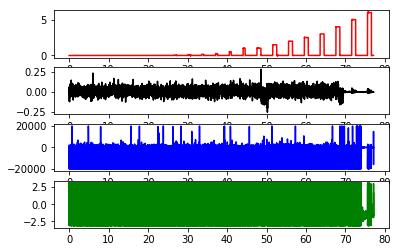

In [73]:
crimson = np.asarray(bl.segments[0].analogsignals[7])

def butter_lowpass_1(highcut, fs, order=10):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='low', analog=False)
    return b, a
 
 

 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass_1(highcut, fs, order)
 
 
muscb2_filt = signal.filtfilt(b, a, musc_det)

ax1 = plt.subplot(411)
ax1.plot(times, crimson, 'r')
 
ax2 = plt.subplot(412, sharex=ax1)
 
ax2.plot(times,muscb2_filt,'k')
 
# perform a Hilbert transformation on the filtered signal to calculate instantaneous phase, amplitude, etc.
from scipy.signal import hilbert
 
musc_analytic = hilbert(muscb2_filt)
inst_phase = np.angle(musc_analytic)

#instantaneous_phase = np.unwrap(np.angle(musc_analytic))
instantaneous_frequency = (np.diff(inst_phase) /(2.0*np.pi) * fs)
 
ax3 = plt.subplot(413, sharex=ax1)
 
# plot the identified ventral flip on the phase data
ax3.plot(times,musc_analytic,'k')
#ax3.plot(times,inst_phase,'r')

times_freq = np.delete(times, 1540096)

ax3.plot(times_freq, instantaneous_frequency, 'b')
#ax3.plot(times[flipInds],inst_phase[flipInds],'g.')

ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(times, inst_phase, 'g')

In [74]:
#ax1 = plt.subplot(611)

#ax1.plot(times_freq, instantaneous_frequency, 'b')
#ax3.plot(times[flipInds],inst_phase[flipInds],'g.')

IndexError: list index out of range

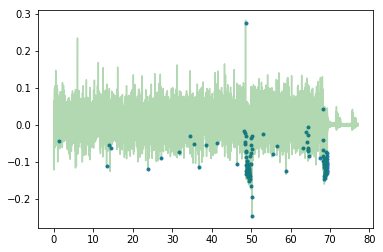

In [78]:
#%%

#x_val_b= x_val

### delete this freq shit also 
import numpy as np
data = musc[x_val_b]
#data = muscb2_filt
import seaborn as sns
data1 = muscb2_filt[x_val_b]
from scipy.signal import savgol_filter

#detect B2 spikes-- Use negative values

#times_between_spikes =  

plt.figure(13)

labeled_b2_spikes= zip(times[x_val_b], muscb2_filt[x_val_b])
ax1 = plt.subplot(111)
#inds_b2 = argrelmin(muscb2_filt[x_val_b], order = 5)
#ax1.plot(times[inds_b2], muscb2_filt[inds_b2], '.')
ax1.plot(times[x_val_b], muscb2_filt[x_val_b], '.')
ax1.plot(times, muscb2_filt, 'g', alpha = 0.3)

def cutoff_3(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Detected_spikes = cutoff_3(0.1, labeled_b2_spikes)

times_k= []
periods = []

for i in range(len(times)):
    for t in range(len(x_val_b)):
        #z = times[x_val_b[t-2]]
        a = times[x_val_b[t]]
        b = times[x_val_b[t-1]]
        c = times[x_val_b[t+1]]
        #d = times[x_val_b[t+2]]
        if t<= 2:
            periods.append(100)
        else:
            times_k.append(times[x_val_b[t]])
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
            #if 
              #  periods.append(a-b)


In [59]:
'''
times_k= []
periods = []



for i in range(len(times)):
    for t in range(len(x_val_b)):
        #z = times[x_val_b[t-2]]
        a = times[x_val_b[t]]
        b = times[x_val_b[t-1]]
        c = times[x_val_b[t+1]]
        #d = times[x_val_b[t+2]]
        if t<= 2:
            periods.append(100)
        else:
            times_k.append(times[x_val_b[t]])
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
            #if 
              #  periods.append(a-b)
'''

'\ntimes_k= []\nperiods = []\n\n\n\nfor i in range(len(times)):\n    for t in range(len(x_val_b)):\n        #z = times[x_val_b[t-2]]\n        a = times[x_val_b[t]]\n        b = times[x_val_b[t-1]]\n        c = times[x_val_b[t+1]]\n        #d = times[x_val_b[t+2]]\n        if t<= 2:\n            periods.append(100)\n        else:\n            times_k.append(times[x_val_b[t]])\n            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4\n            periods.append(avg)\n            #if \n              #  periods.append(a-b)\n'

In [79]:
spike_window = 3
window = 10

times_p =[]
periods =[]

avg = 100

for i in range(len(times)):
    if i in x_val_b[1:]:
        c = x_val_b.index(i)
        a = times[x_val_b[c]]
        b = times[x_val_b[c-1]]
        #c = times[x_val_b[i+1]]
        #d = times[x_val_b[t+2]]
        if c<= 1:
            periods.append(100)
        else:
            times_p.append(times[x_val_b[c]])
            #print ('spike')
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
    else:
        periods.append(avg)
        


In [80]:
print(len(periods))
print(len(times))


1542144
1542144


In [81]:
b2_frequencies = [1/period for period in periods]
len (b2_frequencies)

1542144

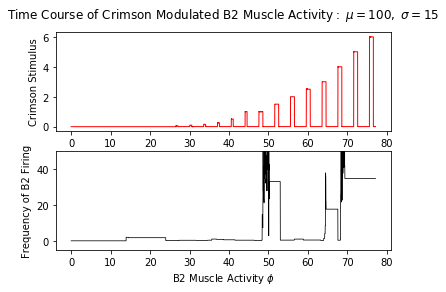

In [82]:

plt.figure(14)

ax1 = plt.subplot(211)
ax1.plot(times, crimson, 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylim(-5, 50)
#savitzky_golay
freq_hat = savgol_filter(b2_frequencies, 75, 11) # window size 51, polynomial order 3

#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)

#ax2.plot(times, freq_hat[:-3],'k', linewidth = 0.75)
ax2.plot(times, b2_frequencies,'k', linewidth = 0.75)

#peristimulus time historgram

#and then compute the Fourier transform as


#plt.title(r'$\mathrm{Histogram\ of\ B2 Muscle Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')

ax1.set_ylabel('Crimson Stimulus', size=10)
ax1.set_title(r'$\mathrm{Time\ Course\ of\ Crimson\ Modulated\ B2\ Muscle\ Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')
ax2.set_ylabel('Frequency of B2 Firing', size=10)
plt.xlabel('B2 Muscle Activity $\phi$', size=10)

import numpy.fft as fft
spectrum = fft.fft(data1)
#You can then plot the magnitudes of the FFT as

In [103]:
b2_frequencies = []

b2_frequencies.append(0)

for t in range(len(times)):
    #if x_val_b[s] != t: 
    for s in range(len(periods)):
        if x_val_b[s] == t:
            a =1/periods[s]
            b2_frequencies.append(a)
        else: 
            a =1/periods[s]    
    #b2_frequencies.append(a)
    if x_val_b[s] != t:
        b2_frequencies.append(a) 
      
'''            
        for i in range(len(periods)):
            a= 1/periods[i]
            #b= a/20000
            b2_frequencies.append(a)
'''

'            \n        for i in range(len(periods)):\n            a= 1/periods[i]\n            #b= a/20000\n            b2_frequencies.append(a)\n'

In [104]:
print(len(b2_frequencies))
print(len(times))

2204703
2204672


ValueError: x and y must have same first dimension, but have shapes (28,) and (2204700,)

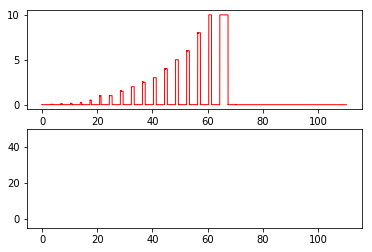

In [137]:
window = 100
freqs=[]

window_array= range(window)

spikes_list = x_val_b #.tolist
    
'''
for i in range(len(muscb2_filt)-10):
    while i < window/2.:
        if i in spikes_list:  
            freqs.append(1)
    while i >= windown/2.:
        counter =0
        for j in window_array:
            if j in spikes_list:
                counter += 1
        freqs.append(counter)
'''


labeled_b2_periods= zip(times_k, b2_frequencies)


plt.figure(14)

ax1 = plt.subplot(211)
ax1.plot(times, crimson, 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylim(-5, 50)
#savitzky_golay
freq_hat = savgol_filter(b2_frequencies, 75, 11) # window size 51, polynomial order 3

#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)

ax2.plot(times_k, freq_hat[:-3],'k', linewidth = 0.75)

#peristimulus time historgram

#and then compute the Fourier transform as


#plt.title(r'$\mathrm{Histogram\ of\ B2 Muscle Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')

ax1.set_ylabel('Crimson Stimulus', size=10)
ax1.set_title(r'$\mathrm{Time\ Course\ of\ Crimson\ Modulated\ B2\ Muscle\ Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')
ax2.set_ylabel('Frequency of B2 Firing', size=10)
plt.xlabel('B2 Muscle Activity $\phi$', size=10)

import numpy.fft as fft
spectrum = fft.fft(data1)
#You can then plot the magnitudes of the FFT as

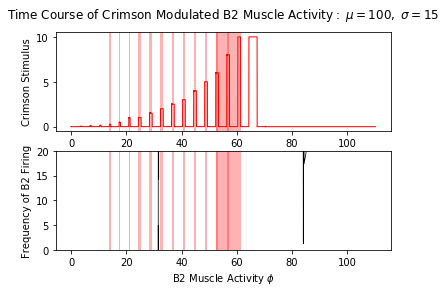

In [45]:
crimson_on = []
crimson_off = []

for c in range(len(crimson)):
    if crimson[c]-crimson[c-1]> 0.2:
        crimson_on.append(c)
    if crimson[c]-crimson[c-1]< -0.2:
        crimson_off.append(c)


fig =plt.figure(14)

ax1 = plt.subplot(211)
ax1.plot(times, crimson, 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylim(0, 20)
#ax2.set_xlim(20, 80)
#savitzky_golay
freq_hat = savgol_filter(b2_frequencies, 7, 5) # window size 51, polynomial order 3
#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)
        
for i in range(len(crimson_off)-1):
    ax1.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)
    ax2.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)

ax2.plot(times_k, freq_hat[:-3],'k', linewidth = 0.75)

#peristimulus time historgram

#and then compute the Fourier transform as


#plt.title(r'$\mathrm{Histogram\ of\ B2 Muscle Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')

ax1.set_ylabel('Crimson Stimulus', size=10)
ax1.set_title(r'$\mathrm{Time\ Course\ of\ Crimson\ Modulated\ B2\ Muscle\ Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')
ax2.set_ylabel('Frequency of B2 Firing', size=10)
plt.xlabel('B2 Muscle Activity $\phi$', size=10)

import numpy.fft as fft
spectrum = fft.fft(data1)
#You can then plot the magnitudes of the FFT as

fname = 'summary_signals_powermuscles_248.pdf'
fig.savefig(fname, format='svg')
fig.savefig(fname, format='pdf')


In [17]:
#%%

import pandas as pd

flydir = '/Users/rohitdesouza/Desktop/data_analysis_01_09/12_15_0005'

B2_spike_times = pd.DataFrame((times_k))
#hist_crimson_spikes.to_csv(flydir + 't4/hist_crimson_spikes.csv', index=False)
B2_spike_times.to_csv(flydir + localfilename + 'B2_spike_times.csv', index=False)

B2_spike_freq = pd.DataFrame((b2_frequencies))
#hist_no_crimson_spikes.to_csv(flydir + 't4/hist_no_crimson_spikes.csv', index=False)
B2_spike_freq.to_csv(flydir + localfilename + 'B2_spikes_times_spikes.csv', index=False)



#%%
plt.figure(15)

ax1 = plt.subplot(411)
ax1.plot(times, crimson, 'r')
 
ax2 = plt.subplot(412, sharex=ax1)
 
ax2.plot(times,muscb2_filt,'k')

ax3 = plt.subplot(413, sharex=ax1)

freq = fft.fftfreq(len(spectrum))
#plot(times[x_val_b], freq)
ax3.plot(times[x_val_b], spectrum)


freq = np.fft.fftfreq(len(spectrum))     
ax4 = plt.subplot(414, sharex=ax1)


#ax4.plot(times[x_val_b], (freq)) #np.gradient(freq))
    
    

#ax4.plot(times[x_val_b], np.gradient(freq)/average(np.gradient(freq))) 
#gradient to be the derivative of numpy array

#ax3.set_ylabel





#plt.rc('font', size=5)

#r'$\mathrm{Histogram\ of\ b1  Activation}$
plt.title(r'$\mathrm{Histogram\ of\ B2 Muscle Activity:}\ \mu=100,\ \sigma=15$', size=15)

ax1.set_ylabel('Crimson Stimulus', size=10)
ax2.set_ylabel('Filtered B2 Activity', size=10)
ax3.set_ylabel('Frequency $\phi$', size=10)


fourier = np.fft.fft(spectrum)
n = spectrum.size
#timestep = 0.1
#freq1 = np.fft.fftfreq(n, d=20000)

ax4.plot(times[x_val_b], (freq))  #np.gradient

ax4.set_ylabel('Frequency', size= 10) # Averaged \Mathtext.cm{f}', size=10)

#ax4.set_ylabel('Frequency', size= 10) # Averaged \Mathtext.cm{f}', size=10)
plt.xlabel('Time')




#%%
#With crimson light!

crimson = np.asarray(bl.segments[0].analogsignals[7])


plt.figure(13)
ax1 = plt.subplot(111)

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

#split via crimson

#ax1.plot(times,crimson,'r')
#plt.fill_between(times[inds],crimson[inds])

#crimson_labeled_spikes_0= zip(inst_phase[x_val], crimson[x_val], musc[x_val])
crimson_labeled_spikes_2= zip(inst_phase[x_val_b], crimson[x_val_b], musc[x_val_b])


def cutoff_crimson(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList2 = filter(lambda x: x[1] > threshold, sortedData)
    finalList =filter(lambda x: x[0] < 45, finalList2)
    return finalList if len(finalList) > 2 else 'No values found'

#Spikes_1_crimson = cutoff_crimson(0.2, crimson_labeled_spikes_0)
Spikes_2_crimson = cutoff_crimson(.2, crimson_labeled_spikes_2)

def cutoff_no_crimson(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList2 = filter(lambda x: x[1] < threshold, sortedData)
    finalList =filter(lambda x: x[0] < 45, finalList2)
    return finalList if len(finalList) > 2 else 'No values found'

#Spikes_1_no_crimson = cutoff_no_crimson(0.2, crimson_labeled_spikes_0)
Spikes_2_no_crimson = cutoff_no_crimson(0.2, crimson_labeled_spikes_2)



#print(zip_hutch)


#x_val_crimson_1 = [x[0] for x in Spikes_1_crimson]
x_val_crimson_2 = [x[0] for x in Spikes_2_crimson] #COMPARING PHASE


#x_val_no_crim_1 = [x[0] for x in Spikes_1_no_crimson]

x_val_no_crim_2 = [x[0] for x in Spikes_2_no_crimson]



#labeled_waveforms_type_a = [musc[pk-25:pk+40] for pk in x_val]

#labeled_waveforms_type_b = [musc[pk-25:pk+40] for pk in x_val_b]


#hist_crimson_spikes = x_val_crimson_1 
#hist_no_crimson_spikes = x_val_no_crim_1 

hist_crimson_spikes = x_val_crimson_2
hist_no_crimson_spikes = x_val_no_crim_2

matplotlib.pyplot.hist(hist_crimson_spikes, bins=30, normed=1, facecolor='red', alpha=0.75)
matplotlib.pyplot.hist(hist_no_crimson_spikes, bins=30, normed=1, facecolor='yellow', alpha=0.55)

####for B2
#matplotlib.pyplot.hist(hist_crimson_spikes, bins=60, normed=1, facecolor='red', alpha=0.75)
#matplotlib.pyplot.hist(hist_no_crimson_spikes, bins=60, normed=1, facecolor='yellow', alpha=0.55)



#mu, sigma = 100, 15
bins = 100
#x = mu + sigma*np.random.randn(10000)

# the histogram of the data
#n, bins, patches = plt.hist(musc_det[x_val_0], 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Rad')
plt.ylabel('Freq')
plt.title(r'$\mathrm{Histogram\ of\ b1  Activation}$')
#plt.title(r'$\mathrm{Histogram\ of\ b2  Activation}$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(False)

plt.show()

# sanity check: just plot instantaneous phase over the whole experiment
#plt.figure(14)
#plt.plot(inst_phase[x_val_b], 'k')

#%% gather a subset of the hütchens before and during a stimulus period to display them overlaid

hutch_seg = hutch[928548:948438]
musc_seg = musc[928548:948438]

deltas = np.diff(np.array(-1*hutch_det[928548:948438]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]

plt.figure(2)
plt.subplot(211)
for i in range(len(hut_waveforms)):
    plt.plot(hut_waveforms[i], 'k', alpha = 0.3)
    
plt.subplot(212)
for i in range(len(musc_wave)):
    plt.plot(musc_wave[i], 'k', alpha = 0.3)



#%% gather a subset of the hütchens before and during a stimulus period to display them overlaid

'''
hutch_seg = hutch[928548:948438]
musc_seg = musc[928548:948438]

deltas = np.diff(np.array(-1*hutch_det[928548:948438]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]

plt.figure(2)
plt.subplot(211)
for i in range(len(hut_waveforms)):
    plt.plot(hut_waveforms[i], 'r', alpha = 0.3)
    
plt.subplot(212)
for i in range(len(musc_wave)):
    plt.plot(musc_wave[i], 'r', alpha = 0.3)
'''
 
#%% save the data (change the trial directory each time)

import pandas as pd

flydir = '/Users/rohitdesouza/Desktop/data_analysis_01_09/12_15_0005'

hist_crimson_spikes = pd.DataFrame((hist_crimson_spikes))
#hist_crimson_spikes.to_csv(flydir + 't4/hist_crimson_spikes.csv', index=False)
hist_crimson_spikes.to_csv(flydir + localfilename + 'hist_crimson_spikes.csv', index=False)

hist_no_crimson_spikes = pd.DataFrame((hist_no_crimson_spikes))
#hist_no_crimson_spikes.to_csv(flydir + 't4/hist_no_crimson_spikes.csv', index=False)
hist_no_crimson_spikes.to_csv(flydir + localfilename + 'hist_no_crimson_spikes.csv', index=False)



#%%
#### 

### Cumulative historgram or regular historgram

### for phase of B1 with and without crimson
###  degree of power muscle activation with and without crimson

#!/usr/bin/env python

plt.figure(13)
ax1 = plt.subplot(211)

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn

#split via crimson

#ax1.plot(times,crimson,'r')
#plt.fill_between(times[inds],crimson[inds])

crimson_labeled_spikes= zip(inst_phase[x_val_b], crimson[x_val_b], musc[x_val_b])


#plto inst phase


def cutoff_crimson(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList2 = filter(lambda x: x[1] > threshold, sortedData)
    finalList =filter(lambda x: x[1] < 45, finalList2)
    return finalList if len(finalList) > 2 else 'No values found'

Spikes_1_crimson = cutoff_crimson(5.0, crimson_labeled_spikes)
#Spikes_2_crimson = cutoff_crimson(0.2, crimson_labeled_spikes_2)

def cutoff_no_crimson(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList2 = filter(lambda x: x[1] < threshold, sortedData)
    finalList =filter(lambda x: x[0] < 45, finalList2)
    return finalList if len(finalList) > 2 else 'No values found'

Spikes_1_no_crimson = cutoff_no_crimson(0.20, crimson_labeled_spikes)
#Spikes_2_no_crimson = cutoff_no_crimson(0.2, crimson_labeled_spikes_2)



#print(zip_hutch)


x_val_crimson_1 = [x[0] for x in Spikes_1_crimson]
###x_val_crimson_2 = [x[2] for x in Spikes_2_crimson]
#x_val_crimson_1 = []

x_val_no_crim_1 = [x[0] for x in Spikes_1_no_crimson]
#x_val_no_crim_1 = []
###x_val_no_crim_2 = [x[2] for x in Spikes_2_no_crimson]
#x_val_no_crim_2 = []

#labeled_waveforms_type_a = [musc[pk-25:pk+40] for pk in x_val]

#labeled_waveforms_type_b = [musc[pk-25:pk+40] for pk in x_val_b]


hist_crimson_spikes = x_val_crimson_1 #+ x_val_crimson_2
hist_no_crimson_spikes = x_val_no_crim_1 #+ x_val_no_crim_2

matplotlib.pyplot.hist(hist_crimson_spikes, bins=50, normed=1, facecolor='red', alpha=0.75)
matplotlib.pyplot.hist(hist_no_crimson_spikes, bins=50, normed=1, facecolor='blue', alpha=0.55)


#mu, sigma = 100, 15
bins = 40
#x = mu + sigma*np.random.randn(10000)

# the histogram of the data
#n, bins, patches = plt.hist(musc_det[x_val_0], 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Phase $\phi$')
plt.ylabel('Incidence of Spikes')
plt.title(r'$\mathrm{Histogram\ of\ b1 Muscle Activation:}\ \mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()



    
#%%

#### Maybe delete this


crimson = np.asarray(bl.segments[0].analogsignals[7])

indices = np.arange(len(crimson))

crimson_time= zip(indices, times, crimson)

def crimson_selection(threshold, data):
    sortedData = sorted(data, key=lambda x: x[2])
    finalList = filter(lambda x: x[2] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

crimson_selection_high = crimson_selection(2.0, crimson_time)



crimson_inds_1= zip(indices, crimson)

def crimson_selection_1(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

crimson_selection_high_1 = crimson_selection_1(2.00, crimson_inds_1)

####a
###Just take wave finder at those times!


def crimson_selection_none(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

crimson_selection_zero_stim = crimson_selection_none(0.1, crimson_inds_1)

print(crimson_selection_high_1[0])

# detrend hütchens signal
hutch_det = hutch - np.mean(hutch)

#hutch_seg = hutch[1260000:1263000]
#musc_seg = musc[1260000:1263000]

hutch_seg = hutch[crimson_selection_high_1[0][0]+1000:crimson_selection_high_1[0][0]+3000]
musc_seg = musc[crimson_selection_high_1[0][0]+1000:crimson_selection_high_1[0][0]+3000]

deltas = np.diff(np.array(-1*hutch_det[crimson_selection_high_1[0][0]+1000:crimson_selection_high_1[0][0]+3000]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]

plt.figure(2)
plt.rc('font', size=12)
plt.rc('axes',linewidth=.5)
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['axes.linewidth'] = 2

fs_axon = 1.0/20000.0
t= np.linspace(0,len(hut_waveforms[0])/(1/fs_axon),len(hut_waveforms[0]))

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('w')

ax = fig.add_subplot(222)

for i in range(len(hut_waveforms)):
    ax.plot(t, hut_waveforms[i], 'r', alpha = 0.5)


ax.spines['left'].set_bounds(0, 2)
ax.set_ylim((-2, 4))
ax.set_xlim((-0.001, .005))
ax.set_yticks([])
ax.set_xticks([])
ax.tick_params(axis='both', which='major', pad=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

    
ax2 = fig.add_subplot(224)
for i in range(len(musc_wave)):
    ax2.plot(t, musc_wave[i], 'r', alpha = 0.5)


ax2.spines['left'].set_bounds(-0.2, 0.2)
ax2.set_ylim((-2, 1.25))
ax2.set_xlim((-0.001, .005))
ax2.set_yticks([])
ax2.set_xticks([])
ax2.tick_params(axis='both', which='major', pad=2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
    
#%%

#hutch_seg = hutch[1010000:1013000]
#musc_seg = musc[1010000:1013000]

hutch_seg = hutch[crimson_selection_high_1[0][0]-5000:crimson_selection_high_1[0][0]-2000]
musc_seg = musc[crimson_selection_high_1[0][0]-5000:crimson_selection_high_1[0][0]-2000]



deltas = np.diff(np.array(-1*hutch_det[crimson_selection_high_1[0][0]-5000:crimson_selection_high_1[0][0]-2000]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]



ax = fig.add_subplot(222)

for i in range(len(hut_waveforms)):
    ax.plot(t, hut_waveforms[i], 'k', alpha = 0.5)

ax.set_ylabel('WBA (rel. units)')
ax.spines['left'].set_bounds(0, 2)
ax.set_ylim((-2, 4))
ax.set_xlim((-0.001, .005))
ax.set_yticks([0, 2])
ax.set_xticks([])
ax.tick_params(axis='both', which='major', pad=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

    
ax2 = fig.add_subplot(224)
for i in range(len(musc_wave)):
    ax2.plot(t, musc_wave[i], 'k', alpha = 0.5)

ax2.set_ylabel('b1 (mV)')
ax2.spines['left'].set_bounds(-0.2, 0.2)
ax2.set_ylim((-2, 1.25))
ax2.set_xlim((-0.001, .005))
ax2.set_yticks([-.2, .2])
ax2.spines['bottom'].set_bounds(-0.001, 0)
ax2.set_xticks([-0.001, 0])
ax2.tick_params(axis='both', which='major', pad=2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['bottom'].set_visible(False)

ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')


    
#%%

####Plot average waveform and std deviation 

import matplotlib.pyplot as plt
import numpy as np


#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]

'''
average_waveform = []


for i in range (len(musc_seg)):
    for j in range (len(musc_wave)):
        average_waveform.append(np.mean(musc_wave[j][i]))
 '''      

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('w')

ax = fig.add_subplot(211)

average_waveform =[]


for i in range(len(hut_waveforms)):
    #ax.plot(t, hut_waveforms[i], 'k', alpha = 0.5)
    average_waveform.append(hut_waveforms[i])



avg_waveform = np.mean(average_waveform, axis=0)
std_dev_wave=np.std(average_waveform, axis=0)   

#pl.fill_between(x, y-error, y+error)

t= np.array(t)
y1= np.array(avg_waveform - std_dev_wave)
y2 = np.array(avg_waveform + std_dev_wave)
#y1.flatten()
#y2.flatten()
flattened_y1 =[]
flattened_y2 = []
flat_times =[]

for x in y1:
    #for y in x:
        flattened_y1.append(x)
        
for x in y2:
    #for y in x:
        flattened_y2.append(x) 
        
for x in t:
    #for y in x:
        flat_times.append(x)
        
t = float32(t)

ax.fill_between(t, y1, y2 , facecolor='blue', alpha = 0.3, interpolate=True)#, 'b', alpha =0.3)#, interpolate=True)
#ax.plot(t, np.mean(hut_waveforms[i]), 'green', alpha =1)

ax.plot(t, avg_waveform, 'k', alpha = 1)

ax.set_ylabel('WBA (rel. units)')
ax.spines['left'].set_bounds(0, 2)
ax.set_ylim((-2, 4))
ax.set_xlim((-0.001, .005))
ax.set_yticks([0, 2])
ax.set_xticks([])
ax.tick_params(axis='both', which='major', pad=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

average_spikes = []
    
ax2 = fig.add_subplot(212)
for i in range(len(musc_wave)):
    #ax2.plot(t, musc_wave[i], 'k', alpha = 0.5)
    average_spikes.append(musc_wave[i])

avg_spikes = np.mean(average_spikes, axis=0) 
std_dev_spikes=np.std(average_spikes, axis=0)

y3= (avg_spikes - std_dev_spikes)
y4 = (avg_spikes + std_dev_spikes) 
t = float32(t)
ax2.fill_between(t, y3, y4, facecolor = 'b', alpha =0.3, interpolate=True)  

ax2.plot(t, avg_spikes, 'k', alpha = 1)

'''
ax2.set_ylabel('b1 (mV)')
ax2.spines['left'].set_bounds(-0.2, 0.2)
ax2.set_ylim((-2, 1.25))
ax2.set_xlim((-0.001, .005))
ax2.set_yticks([-.2, .2])
ax2.spines['bottom'].set_bounds(-0.001, 0)
ax2.set_xticks([-0.001, 0])
ax2.tick_params(axis='both', which='major', pad=2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['bottom'].set_visible(False)

ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
'''
    
#%%

#hutch_seg = hutch[1010000:1013000]
#musc_seg = musc[1010000:1013000]

hutch_seg = hutch[crimson_selection_high_1[0][0]+1000:crimson_selection_high_1[0][0]+3000]
musc_seg = musc[crimson_selection_high_1[0][0]+1000:crimson_selection_high_1[0][0]+3000]



deltas = np.diff(np.array(-1*hutch_det[crimson_selection_high_1[0][0]+1000:crimson_selection_high_1[0][0]+3000]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]

average_waveform_crim =[]



for i in range(len(hut_waveforms)):
    #ax.plot(t, hut_waveforms[i], 'k', alpha = 0.5)
    average_waveform_crim.append(hut_waveforms[i])
    
avg_waveform_crim = np.mean(average_waveform_crim, axis=0)
std_dev_wave_crim=np.std(average_waveform_crim, axis=0)

y7=avg_waveform_crim - std_dev_wave_crim
y8=avg_waveform_crim + std_dev_wave_crim

ax.fill_between(t, y7, y8 , facecolor='red', alpha = 0.3, interpolate=True)#, 'b', alpha =0.3)#, interpolate=True)
#ax.plot(t, np.mean(hut_waveforms[i]), 'green', alpha =1)

ax.plot(t, avg_waveform_crim, 'r', alpha = 1)

ax = fig.add_subplot(212)
    
'''    
ax.set_ylabel('WBA (rel. units)')
ax.spines['left'].set_bounds(0, 2)
ax.set_ylim((-2, 4))
ax.set_xlim((-0.001, .005))
ax.set_yticks([0, 2])
ax.set_xticks([])
ax.tick_params(axis='both', which='major', pad=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
'''

average_spikes_crim = []
    
ax2 = fig.add_subplot(212)
for i in range(len(musc_wave)):
    #ax2.plot(t, musc_wave[i], 'k', alpha = 0.5)
    average_spikes_crim.append(musc_wave[i])
    
    
avg_spikes_crim = np.mean(average_spikes_crim, axis=0) 
std_dev_spikes_crim=np.std(average_spikes_crim, axis=0)

y5= (avg_spikes_crim - std_dev_spikes_crim)
y6 = (avg_spikes_crim + std_dev_spikes_crim) 
t = float32(t)
ax2.fill_between(t, y5, y6, facecolor = 'r', alpha =0.3, interpolate=True)  

ax2.plot(t, avg_spikes_crim, 'r', alpha = 1)




    
#%%

NameError: name 'localfilename' is not defined